## Generating WGN

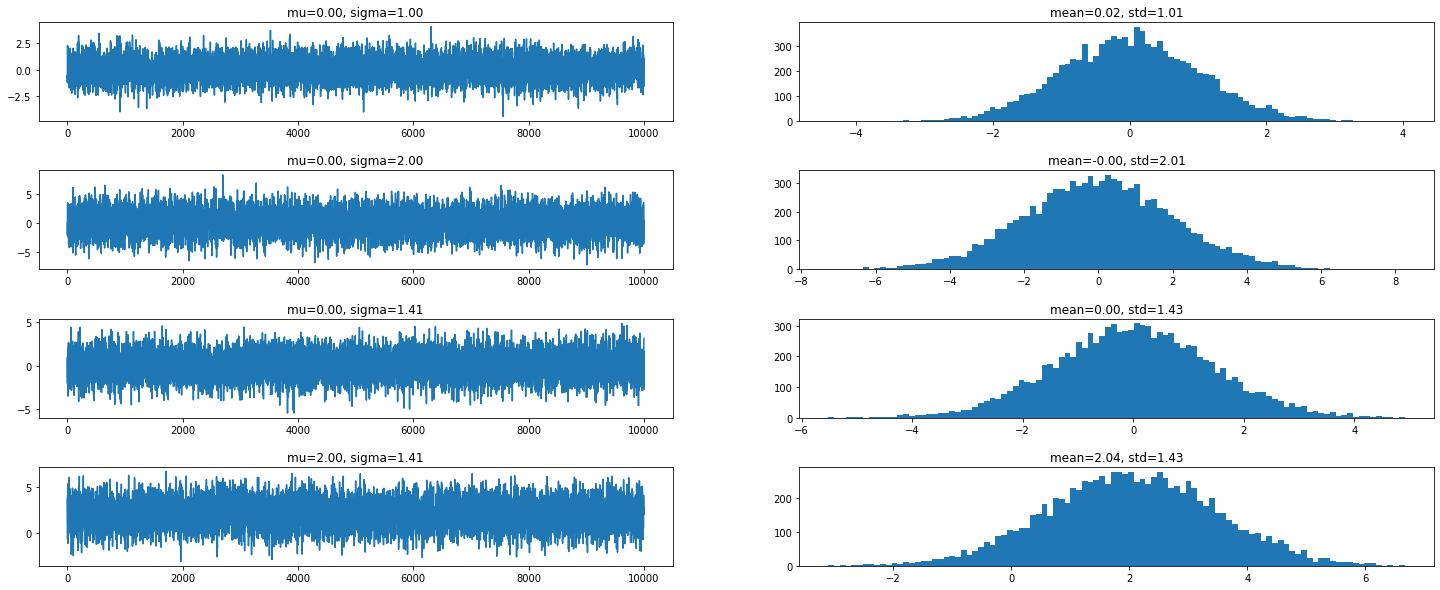

In [2]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4, 2, figsize=(25, 10))
fig.subplots_adjust(hspace=0.5)
Nsample = 10000

for (mu, sigma), ax_line in zip([(0, 1), (0, 2), (0, np.sqrt(2)), (2, np.sqrt(2))], ax):
    wgn = np.random.normal(mu, sigma, Nsample)
    ax_sig, ax_hist = ax_line
    ax_sig.plot(wgn)
    ax_hist.hist(wgn, bins=100)
    ax_sig.set_title('mu={:.2f}, sigma={:.2f}'.format(mu, sigma))
    ax_hist.set_title('mean={:.2f}, std={:.2f}'.format(np.mean(wgn), np.std(wgn)))


## Colored Gaussian Noise

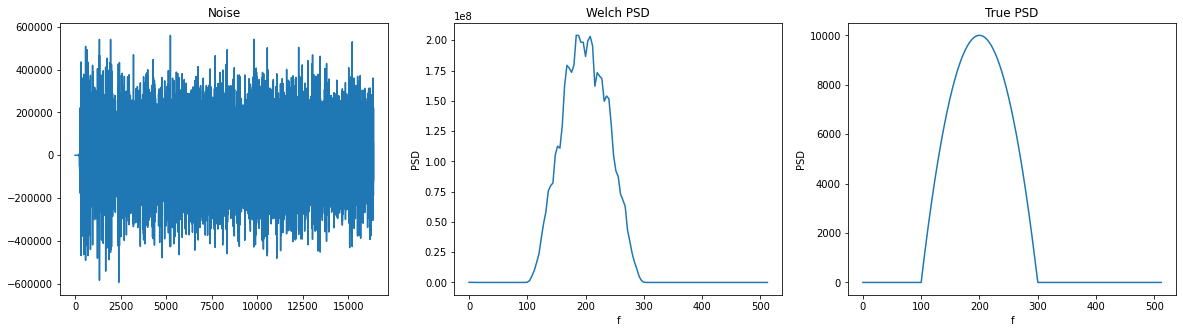

In [21]:
def stat_gaussian_noise(nsamples, sampling_freq, psd_freq, psd, filter_order):
    filter = signal.firwin2(filter_order+1, psd_freq, psd, fs=sampling_freq)
    wgn = np.random.normal(0, 1, nsamples)
    return np.sqrt(sampling_freq) * signal.lfilter(filter, 1, wgn)


fs = 1024
nsamples = 16384
filter_order = 500

psd_freq = np.linspace(0, fs/2, 5121)
psd_value = (psd_freq-100)*(300-psd_freq)
psd_value[np.logical_or(psd_freq < 100, psd_freq > 300)] = 0

noise = stat_gaussian_noise(nsamples, fs, psd_freq, psd_value, filter_order)
noise_psd_f, noise_psd = signal.welch(noise, fs, nperseg=256)

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].plot(noise)
ax[0].set_title('Noise')
ax[1].plot(noise_psd_f, noise_psd)
ax[1].set_title('Welch PSD')
ax[2].plot(psd_freq, psd_value)
ax[2].set_title('True PSD')
for axi in ax[1:]:
    axi.set_xlabel('f')
    axi.set_ylabel('PSD')


## Simulating LIGO noise

Text(0, 0.5, '$\\sqrt{S_n(f)}$')

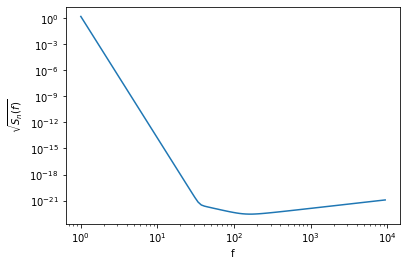

In [4]:
ligo_sensitivity = np.loadtxt('iLIGOSensitivity.txt')
ligo_asd_f, ligo_asd = ligo_sensitivity[:, 0], ligo_sensitivity[:, 1]
plt.loglog(ligo_asd_f, ligo_asd)
plt.xlabel('f')
plt.ylabel(r'$\sqrt{S_n(f)}$')

In [36]:
from scipy import interpolate

fs = 4096
nsamples = 16384

ligo_asd_f_fix = ligo_asd_f.copy()
ligo_asd_fix = ligo_asd.copy()
ligo_asd_f_fix = np.hstack([0, ligo_asd_f_fix[ligo_asd_f < fs/2], fs/2])
ligo_asd_fix = np.hstack(
    [ligo_asd_fix[0], ligo_asd[ligo_asd_f < fs/2], ligo_asd_fix[-1]])

ligo_asd_fix[ligo_asd_f_fix < 50] = ligo_asd_fix[np.argmin(
    np.abs(ligo_asd_f_fix-50))]
ligo_asd_fix[ligo_asd_f_fix > 700] = ligo_asd_fix[np.argmin(
    np.abs(ligo_asd_f_fix-700))]

asd_interpolator = interpolate.interp1d(ligo_asd_f_fix, ligo_asd_fix**2, kind='cubic')
f_interp = np.linspace(0, fs/2, 5121)
psd_interp = asd_interpolator(f_interp)

ligo_noise = stat_gaussian_noise(
    nsamples, fs, f_interp, psd_interp, filter_order=500)
noise_psd_f, noise_psd = signal.welch(ligo_noise, fs, nperseg=256)


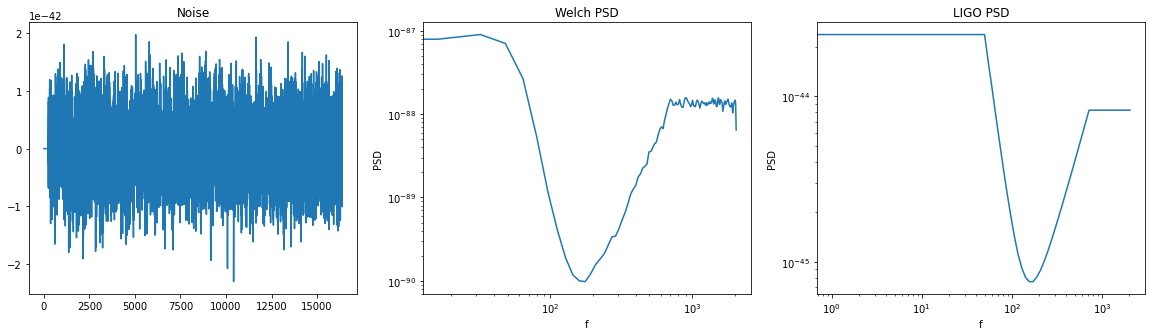

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].plot(ligo_noise)
ax[0].set_title('Noise')
ax[1].plot(noise_psd_f, noise_psd)
ax[1].set_title('Welch PSD')
ax[2].plot(ligo_asd_f_fix, ligo_asd_fix**2)
ax[2].set_title('LIGO PSD')
for axi in ax[1:]:
    axi.set_xlabel('f')
    axi.set_ylabel('PSD')
    axi.set_xscale('log')
    axi.set_yscale('log')